<a href="https://colab.research.google.com/github/Sindhee/IIRS_ISRO_Internship_Project/blob/main/resnet50_mam_shown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.6 MB/s eta 0:00:00


In [ ]:
#resnet50 for binary segmentation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add,
                                     ZeroPadding2D, MaxPooling2D, AveragePooling2D, Dropout, UpSampling2D)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    # Identity block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    # Convolutional block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(256, 256, 3), classes=1):
    # Define ResNet50 modified for binary segmentation
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stages 2, 3, and 4
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Segmentation output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)

    # Upsample to match input dimensions (e.g., 32x upsampling for 256x256 output)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')

    return model

# Compile the model
model = ResNet50(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#correct

def ResNet50(input_shape=(256, 256, 3), classes=1):
    # Define ResNet50 modified for binary segmentation
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)  # Updated with padding='same'
    print("After initial Conv & MaxPooling:", X.shape)


    # Stages 2, 3, and 4 with debug prints
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    print("Convolutional Block 2a output shape:", X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    print("Identity Block 2b output shape:", X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    print("Identity Block 2c output shape:", X.shape)

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    print("Convolutional Block 3a output shape:", X.shape)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    print("Identity Block 3b output shape:", X.shape)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    print("Identity Block 3c output shape:", X.shape)

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    print("Convolutional Block 4a output shape:", X.shape)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    print("Identity Block 4b output shape:", X.shape)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    print("Identity Block 4c output shape:", X.shape)

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)
    print("After AveragePooling:", X.shape)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Segmentation output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)
    print("After final Conv layer:", X.shape)

    # Upsample to match input dimensions (e.g., 32x upsampling for 256x256 output)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)
    print("Final output shape (after upsampling):", X.shape)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')

    return model

# Compile the model
model = ResNet50(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


After initial Conv & MaxPooling: (None, 63, 63, 64)
Convolutional Block 2a output shape: (None, 63, 63, 256)
Identity Block 2b output shape: (None, 63, 63, 256)
Identity Block 2c output shape: (None, 63, 63, 256)
Convolutional Block 3a output shape: (None, 32, 32, 512)
Identity Block 3b output shape: (None, 32, 32, 512)
Identity Block 3c output shape: (None, 32, 32, 512)
Convolutional Block 4a output shape: (None, 16, 16, 1024)
Identity Block 4b output shape: (None, 16, 16, 1024)
Identity Block 4c output shape: (None, 16, 16, 1024)
After AveragePooling: (None, 8, 8, 1024)
After final Conv layer: (None, 8, 8, 1)
Final output shape (after upsampling): (None, 256, 256, 1)


In [ ]:
import numpy as np
import tensorflow as tf
import rasterio
import os
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self,
                 image_folder,
                 mask_folder,
                 target_size=(256, 256),
                 test_size=0.3,
                 val_split=0.5,
                 max_files=1000):
        """
        Initialize data preprocessor for building extraction dataset.

        Args:
            image_folder (str): Path to satellite image TIFF files
            mask_folder (str): Path to mask TIFF files
            target_size (tuple): Desired image and mask dimensions
            test_size (float): Proportion of data to reserve for testing
            val_split (float): Proportion of test data to use for validation
            max_files (int): Maximum number of files to use
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.test_size = test_size
        self.val_split = val_split
        self.max_files = max_files

        # Sort and limit the number of files to `max_files`
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]



    def load_tiff_dataset(self):
        """
        Load TIFF images and masks, handling potential errors.

        Returns:
            tuple: Numpy arrays of images and masks
        """
        all_images = []
        all_masks = []

        for img_file, mask_file in zip(self.image_files, self.mask_files):
            try:
                # Load image (RGB channels)
                with rasterio.open(os.path.join(self.image_folder, img_file)) as src:
                    img_array = src.read([1, 2, 3])
                    img_array = np.moveaxis(img_array, 0, -1)

                # Load mask
                with rasterio.open(os.path.join(self.mask_folder, mask_file)) as src:
                    mask_array = src.read(1)

                all_images.append(img_array)
                all_masks.append(mask_array)

            except Exception as e:
                print(f"Error processing {img_file} or {mask_file}: {e}")

        return np.array(all_images), np.array(all_masks)

    def preprocess_data(self, images, masks):
      processed_images = []
      processed_masks = []

      for img, mask in zip(images, masks):
          if np.any(np.isnan(img)) or np.any(np.isnan(mask)):
              print("NaN detected in input, skipping...")
              continue

          # Resize image
          resized_img = tf.image.resize(
              img,
              self.target_size,
              method=tf.image.ResizeMethod.BILINEAR
          ).numpy()

          # Resize mask
          resized_mask = tf.image.resize(
              mask[..., np.newaxis],
              self.target_size,
              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
          ).numpy().squeeze()

          # Normalize image
          normalized_img = np.clip(resized_img.astype('float32') / 255.0, 0, 1)

          # Normalize mask (binary)
          normalized_mask = np.clip((resized_mask > 0).astype('float32'), 0, 1)

          processed_images.append(normalized_img)
          processed_masks.append(normalized_mask)
          print(f"Image shape before resizing: {img.shape}")
          print(f"Mask shape before resizing: {mask.shape}")
          print(f"Image shape after resizing: {resized_img.shape}")
          print(f"Mask shape after resizing: {resized_mask.shape}")

      print(f"Preprocessed images shape: {np.array(processed_images).shape}")
      print(f"Preprocessed masks shape: {np.array(processed_masks).shape}")

      return np.array(processed_images), np.array(processed_masks)



    def split_dataset(self, images, masks):
        """
        Split dataset into train, validation, and test sets.

        Args:
            images (np.array): Preprocessed images
            masks (np.array): Preprocessed masks

        Returns:
            dict: Dictionary containing split datasets
        """
        # First split: train vs test
        train_images, temp_images, train_masks, temp_masks = train_test_split(
            images, masks, test_size=self.test_size, random_state=42
        )

        # Second split: validation from test set
        val_images, test_images, val_masks, test_masks = train_test_split(
            temp_images, temp_masks, test_size=self.val_split, random_state=42
        )

        return {
            'train_images': train_images,
            'train_masks': train_masks,
            'val_images': val_images,
            'val_masks': val_masks,
            'test_images': test_images,
            'test_masks': test_masks
        }

    def create_tf_datasets(self, datasets, batch_size=4):
        """
        Create TensorFlow datasets with optimal configuration.

        Args:
            datasets (dict): Split datasets
            batch_size (int): Batch size for training

        Returns:
            dict: TensorFlow datasets for train, validation, and test
        """
        tf_datasets = {}

        for key in ['train', 'val', 'test']:
            images = datasets[f'{key}_images']
            masks = datasets[f'{key}_masks']

            dataset = tf.data.Dataset.from_tensor_slices((images, masks))

            if key == 'train':
                dataset = (dataset
                           .shuffle(buffer_size=len(images))
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))
            else:
                dataset = (dataset
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))

            tf_datasets[f'{key}_dataset'] = dataset

        return tf_datasets

# Usage Example
preprocessor = DataPreprocessor(
    image_folder='/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff/',
    mask_folder='/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/',
    max_files=1000  # Limit to 1000 files
)


# Load and preprocess data
images, masks = preprocessor.load_tiff_dataset()
preprocessed_images, preprocessed_masks = preprocessor.preprocess_data(images, masks)

# Split datasets
split_datasets = preprocessor.split_dataset(preprocessed_images, preprocessed_masks)

# Create TensorFlow datasets
tf_datasets = preprocessor.create_tf_datasets(split_datasets)

# Model training preparation
train_dataset = tf_datasets['train_dataset']
val_dataset = tf_datasets['val_dataset']
test_dataset = tf_datasets['test_dataset']

def preprocess_images_and_masks(images, masks):
    masks = tf.expand_dims(masks, axis=-1)
    print(f"Expanded mask shape: {masks.shape}")
    masks = tf.cast(masks, tf.float32)
    print(f"Preprocessed image shape: {images.shape}, Preprocessed mask shape: {masks.shape}")
    return images, masks


train_dataset = train_dataset.map(preprocess_images_and_masks)
val_dataset = val_dataset.map(preprocess_images_and_masks)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Imag

In [ ]:
# using dataset where 2.5 m= 1 pixel (down)

In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Cosine Learning Rate Scheduler
def cosine_lr_scheduler(epoch, total_epochs, initial_lr=1e-4):
    """
    Cosine annealing learning rate scheduler.

    Args:
        epoch (int): Current epoch number
        total_epochs (int): Total training epochs
        initial_lr (float): Initial learning rate

    Returns:
        float: Adjusted learning rate
    """
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
    return initial_lr * cosine_decay

# Dice Coefficient Metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice coefficient for binary segmentation.

    Args:
        y_true (tensor): Ground truth masks
        y_pred (tensor): Predicted masks
        smooth (float): Smoothing factor to prevent division by zero

    Returns:
        tensor: Dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Function to Compile and Train Model
def compile_and_train_model(model, train_dataset, val_dataset):
    """
    Compile and train the model with the specified datasets.

    Args:
        model (tf.keras.Model): The model to train.
        train_dataset (tf.data.Dataset): Training dataset.
        val_dataset (tf.data.Dataset): Validation dataset.

    Returns:
        History: Training history object.
    """
    # Hyperparameters
    batch_size = 4
    total_epochs = 50
    initial_learning_rate = 0.0001

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

    # Learning Rate Scheduler
    lr_schedule = LearningRateScheduler(
        lambda epoch: cosine_lr_scheduler(epoch, total_epochs, initial_learning_rate)
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        lr_schedule
    ]

    # Model Compilation
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=2),
            dice_coefficient
        ]
    )

    for batch in train_dataset.take(1):
        x_batch, y_batch = batch
        print(f"Train batch image shape: {x_batch.shape}, Train batch mask shape: {y_batch.shape}")


    # Model Training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=total_epochs,
        callbacks=callbacks
    )

    return history

# Training preparation
# Assuming `train_dataset` and `val_dataset` are preloaded tf.data.Dataset objects
history = compile_and_train_model(model, train_dataset, val_dataset)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Train batch image shape: (4, 256, 256, 3), Train batch mask shape: (4, 256, 256, 1)
Epoch 1/50
175/175 [==============================] - 486s 3s/step - loss: 18.9495 - accuracy: 0.9941 - mean_io_u: 0.4971 - dice_coefficient: 0.0090 - val_loss: 11.8850 - val_accuracy: 0.9943 - val_mean_io_u: 0.4971 - val_dice_coefficient: 0.0090 - lr: 1.0000e-04
Epoch 2/50
175/175 [==============================] - 461s 3s/step - loss: 8.2638 - accuracy: 0.9942 - mean_io_u: 0.4971 - dice_coefficient: 0.0139 - val_loss: 5.5413 - val_accuracy: 0.9943 - val_mean_io_u: 0.4971 - val_dice_coefficient: 0.0040 - lr: 9.9901e-05
Epoch 3/50
175/175 [==============================] - 456s 3s/step - loss: 4.0027 - accuracy: 0.9942 - mean_io_u: 0.4971 - dice_coefficient: 0.0182 - val_loss: 2.8091 - val_accuracy: 0.9943 - val_mean_io_u: 0.4971 - val_dice_coefficient: 0.0036 - lr: 9.9606e-05
Epoch 4/50
175/175 [==============================] - 456s 3s/step - loss: 2.0853 - accuracy: 0.9941 - mean_io_u: 0.4971 - dice_

KeyboardInterrupt: 

1/1 [==============================] - 0s 66ms/step


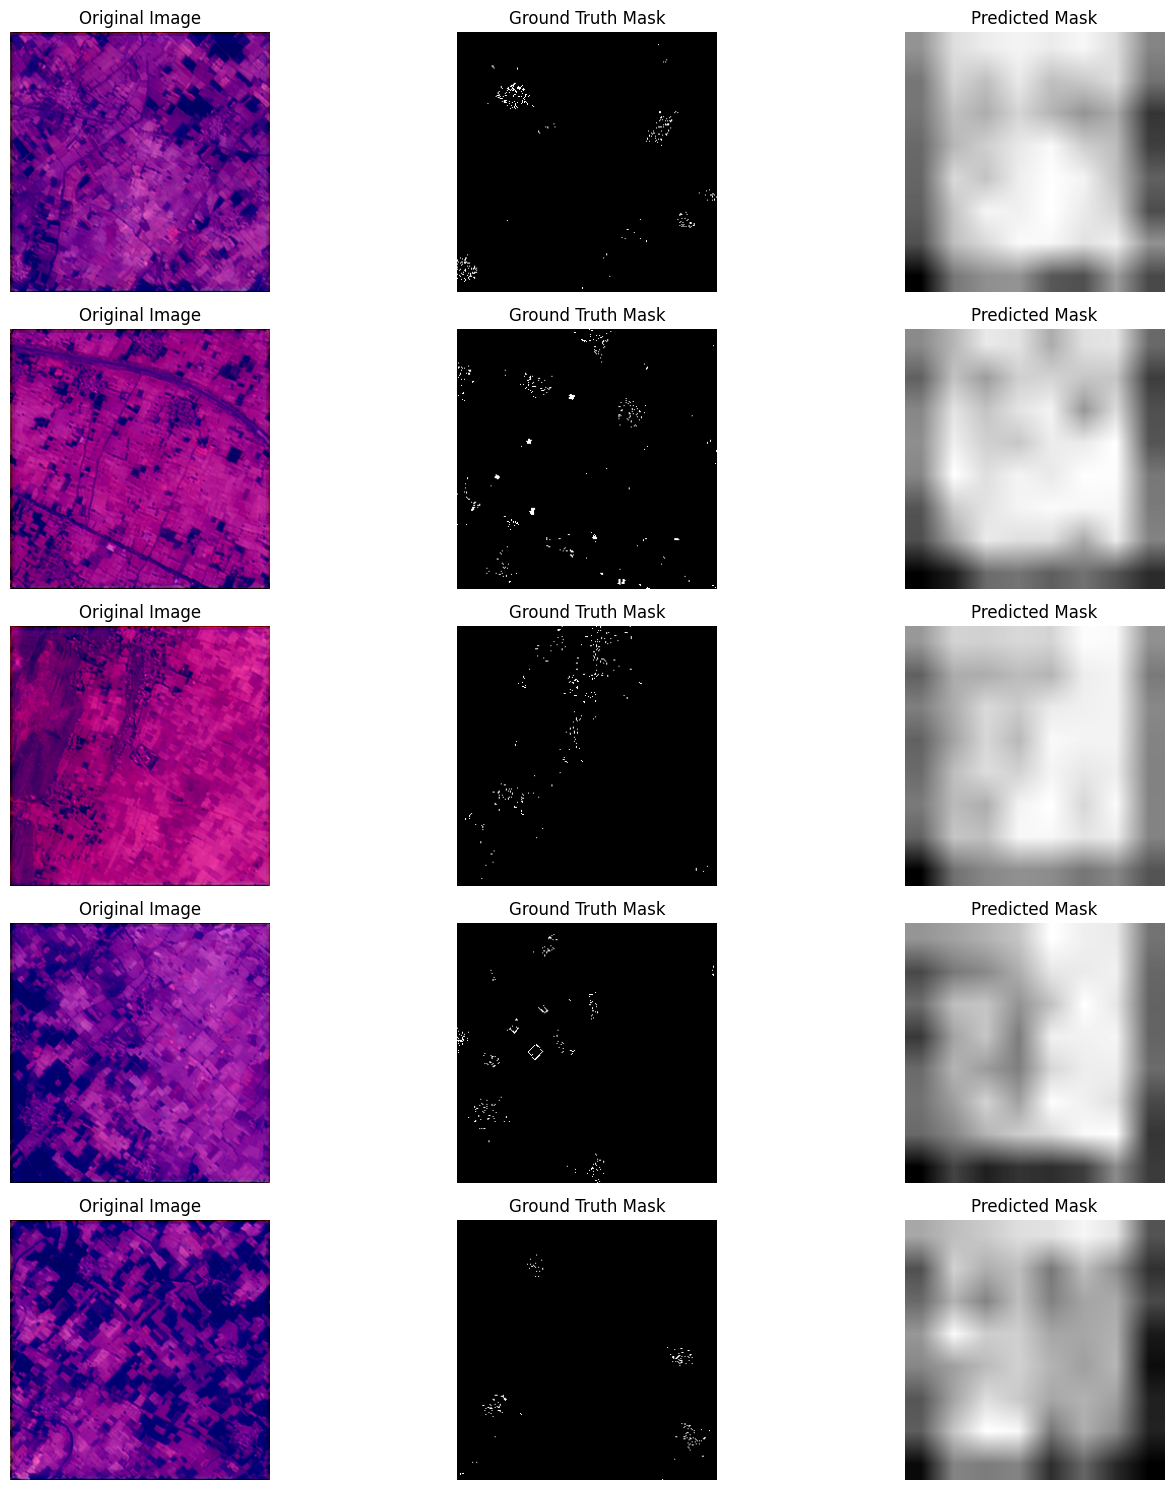

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose some random images from the validation set
num_images = 5  # Number of images to visualize
random_indices = np.random.choice(len(X_val), num_images)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(X_val[idx])  # Display the original image
    ax.set_title("Original Image")
    plt.axis("off")

    # Ground truth mask
    ax = plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')  # Squeeze the mask to remove extra dimensions if any
    ax.set_title("Ground Truth Mask")
    plt.axis("off")

    # Model prediction
    pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0))[0]  # Make a prediction for the image
    ax = plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap='gray')  # Display the predicted mask
    ax.set_title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
